# Data description

For this challenge, you are given (simulated) manufacturing control data that can be clustered into different control states. Your task is to cluster the data into these control states. You are not given any training data, and you are not told how many possible control states there are. This is a completely unsupervised problem, one you might encounter in a real-world setting.

The data includes continuous and categorical data; your task is to predict which rows should be clustered together in a control state

# Imports

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# test

# Load

In [43]:
df = pd.read_csv('../data/raw/data.csv')
df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


# EDA

## Structure investigation

In [44]:
df.shape

(98000, 30)

In [45]:
# Count how many times each data type is present
pd.value_counts(df.dtypes)

float64    22
int64       8
dtype: int64

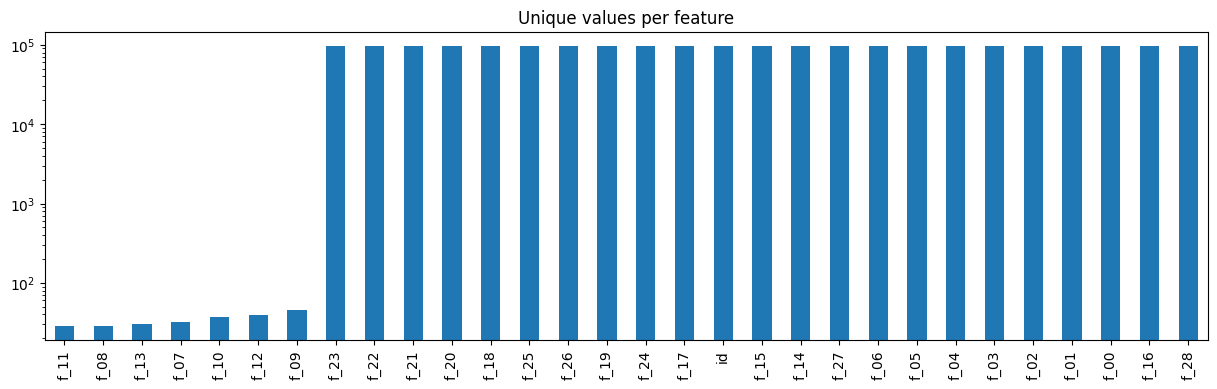

In [46]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

Here, f_07 to f_13 are categorical, whilst all the other features are continuous.

# Quality investigation

### Duplicates

In [47]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df.drop(labels=["id"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


### Missing values

In [48]:
df.isnull().sum().sort_values(ascending=False).head()

id      0
f_00    0
f_27    0
f_26    0
f_25    0
dtype: int64

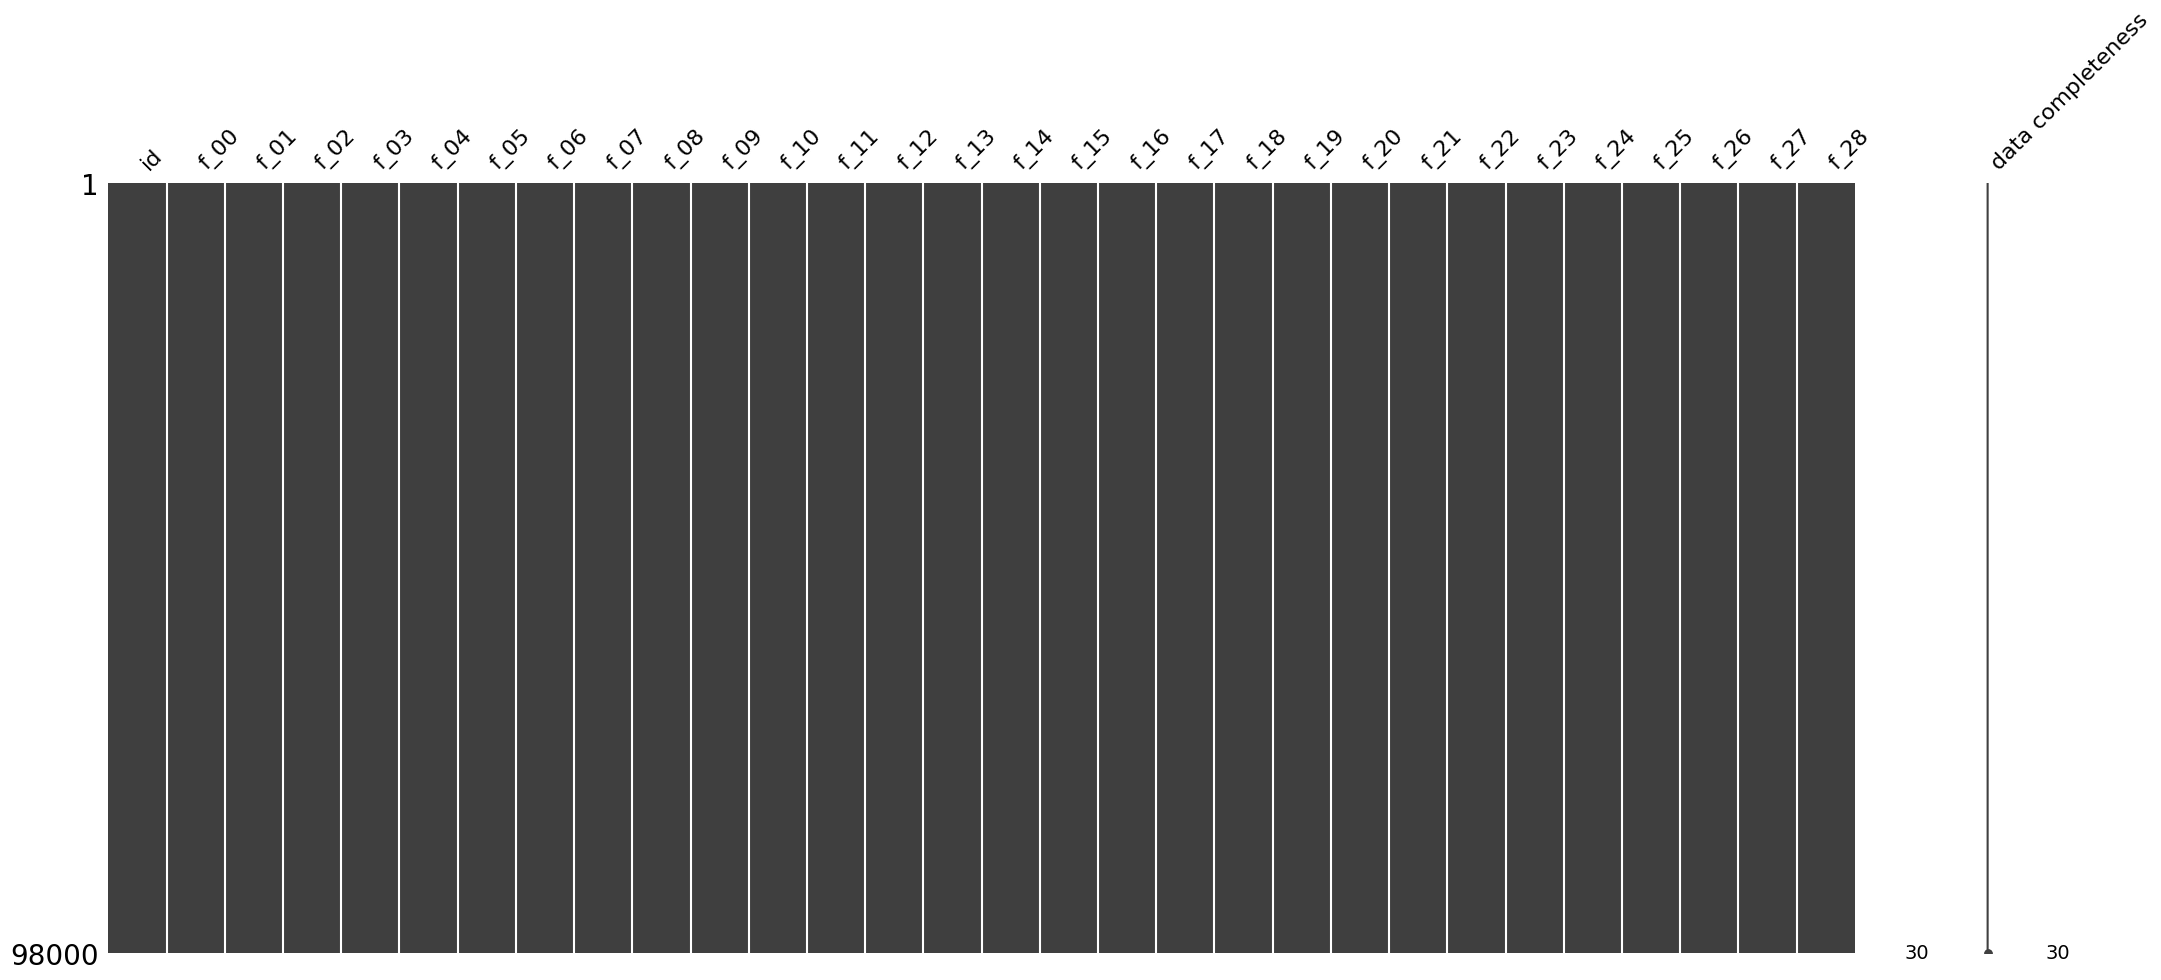

In [49]:
import missingno as msno

msno.matrix(df, labels=True, sort="descending");

## Content investigation

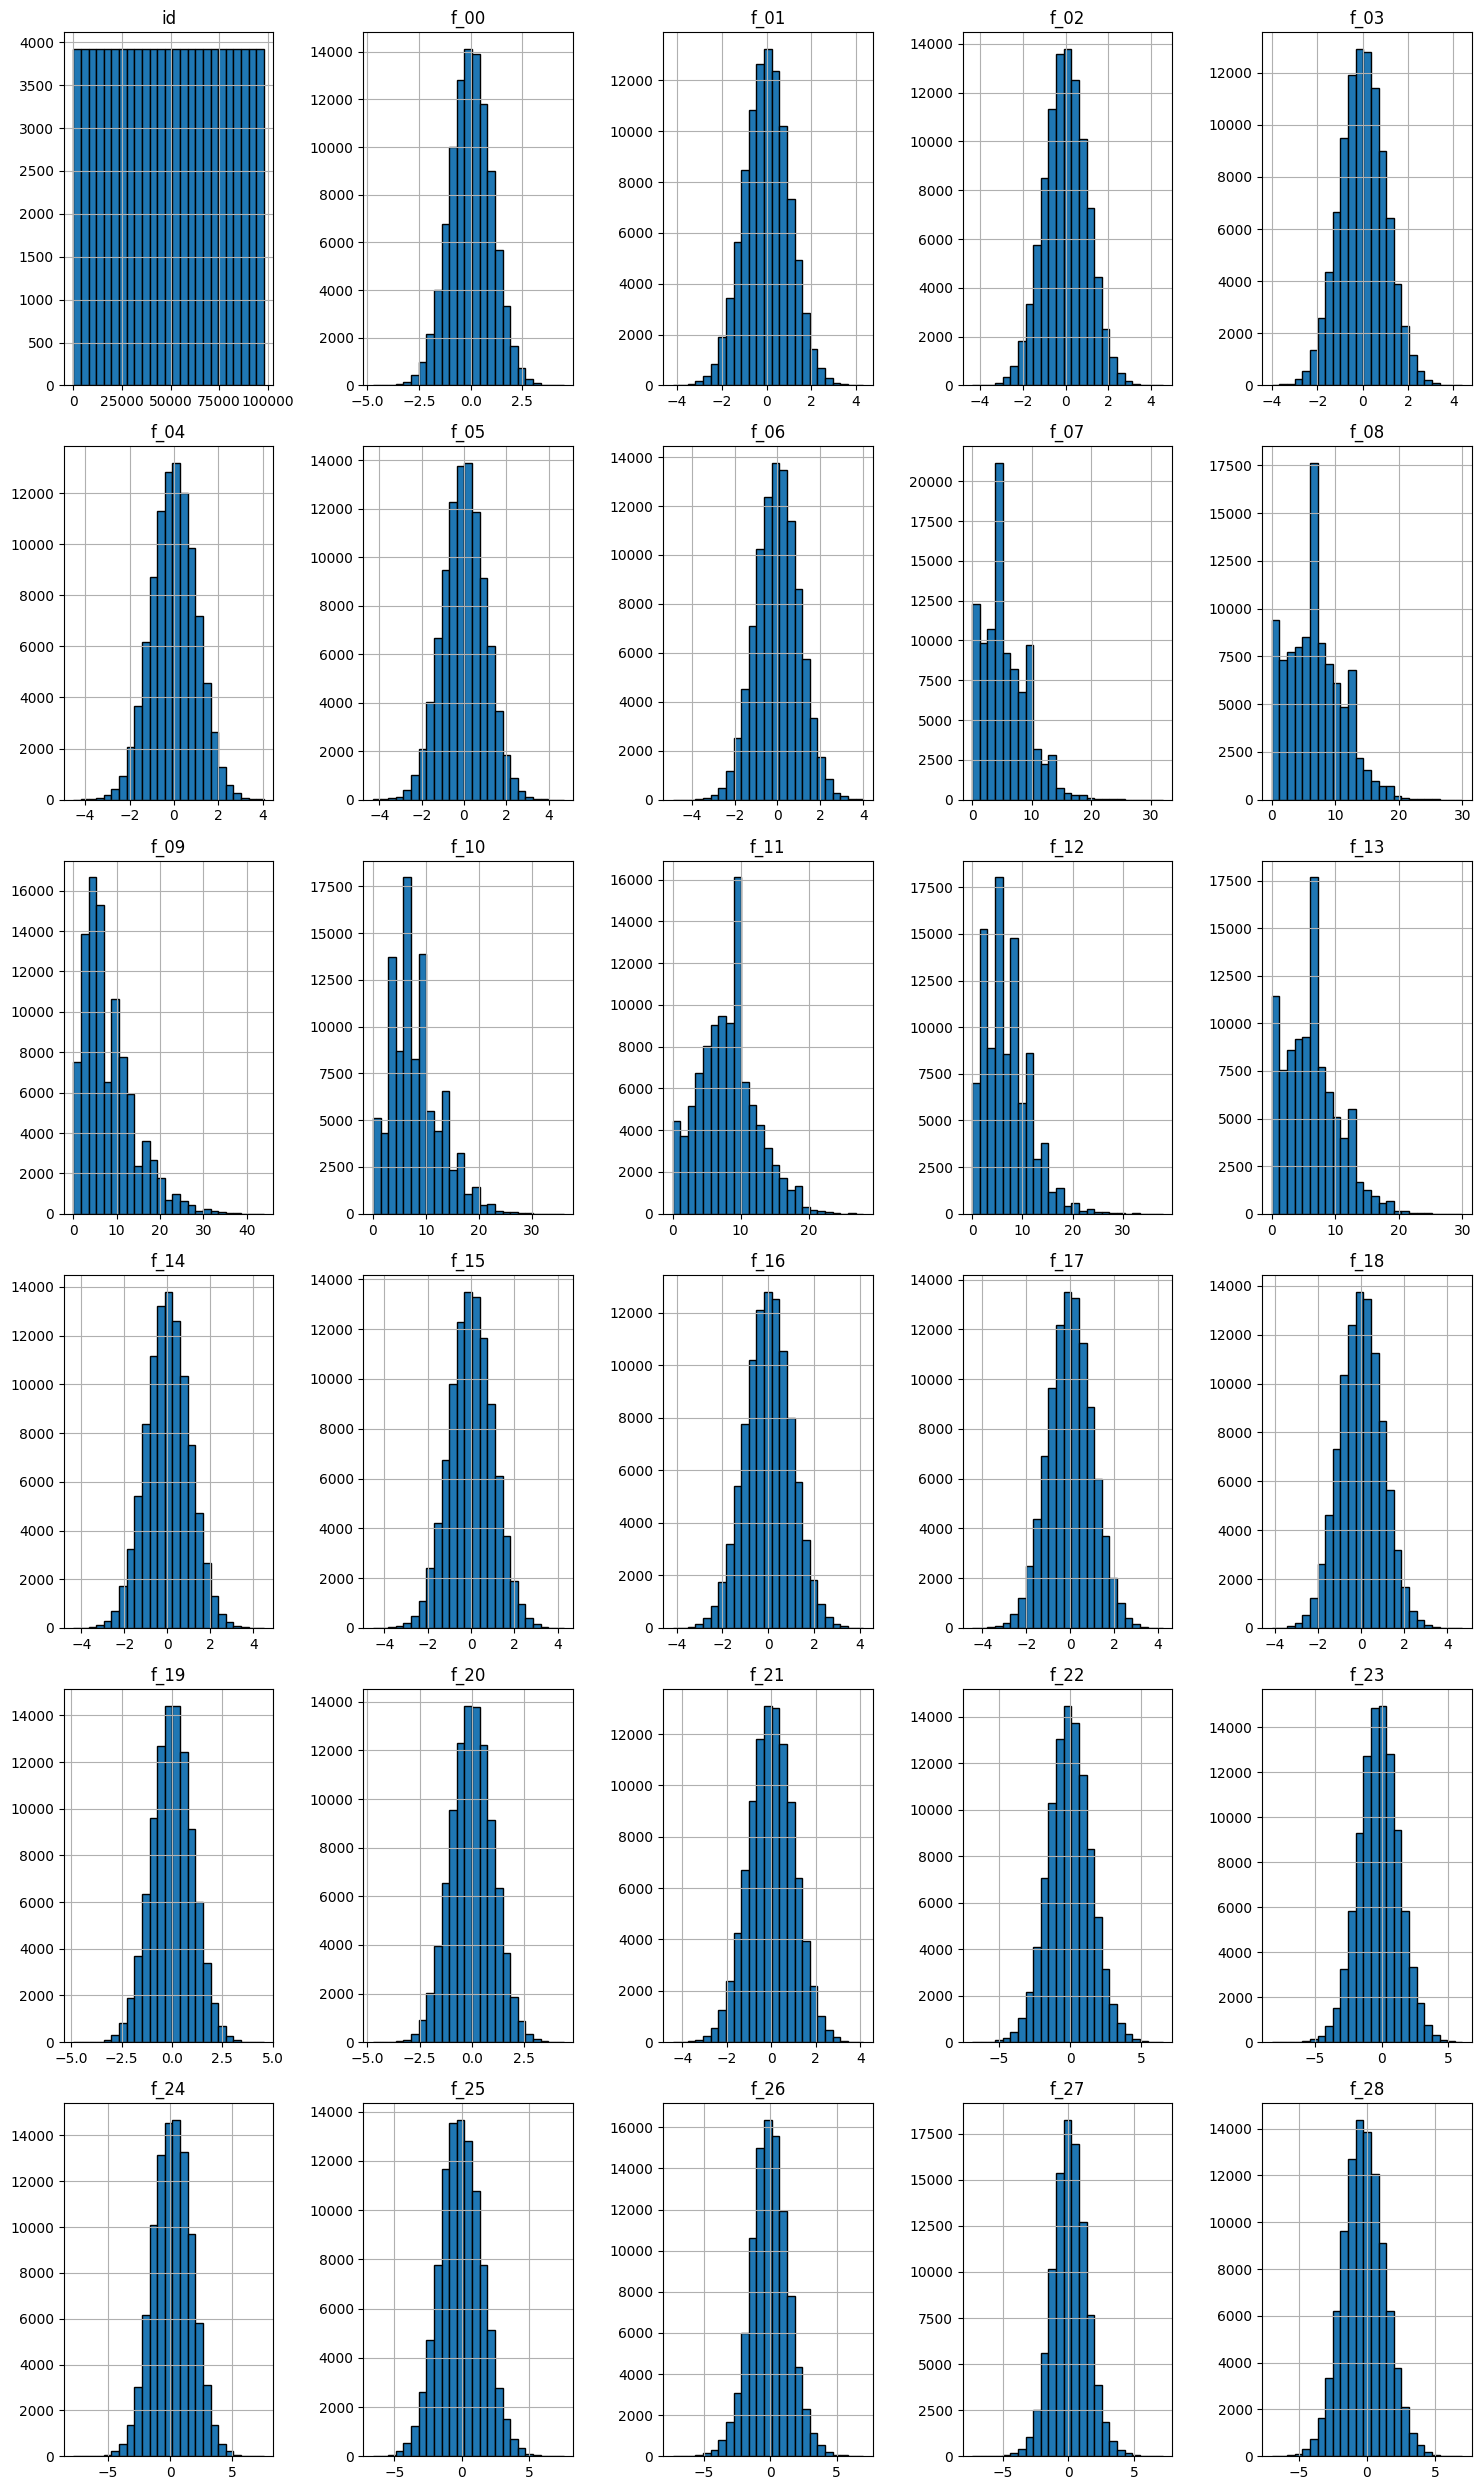

In [50]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

Observations
- All of the continuous variables are normally distributed with mean 0.
- The categorical variables are all right-skewed.

In [51]:
df.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,...,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,...,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,...,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,...,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,...,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,...,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,...,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,...,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


## Feature patterns

In [64]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df.select_dtypes(include="number").nunique() >= 50

In [66]:
df_continuous = df[cols_continuous[cols_continuous].index]
df_continuous.shape

(98000, 23)

In [ ]:
sns.pairplot(df_continuous.iloc[:, :5], height=1.5, plot_kws={"s": 2, "alpha": 0.2});

## Discrete/ordinal features

Plots here not particulary useful as so many variables and they are randomly generated (not many patterns)

In [70]:
df_discrete = df[cols_continuous[~cols_continuous].index]
df_discrete.shape

(98000, 7)

/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/197555158.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/197555158.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/197555158.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/197555158.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
/var/folders/bm/q77j4spj5nsbdchm0916yf5r

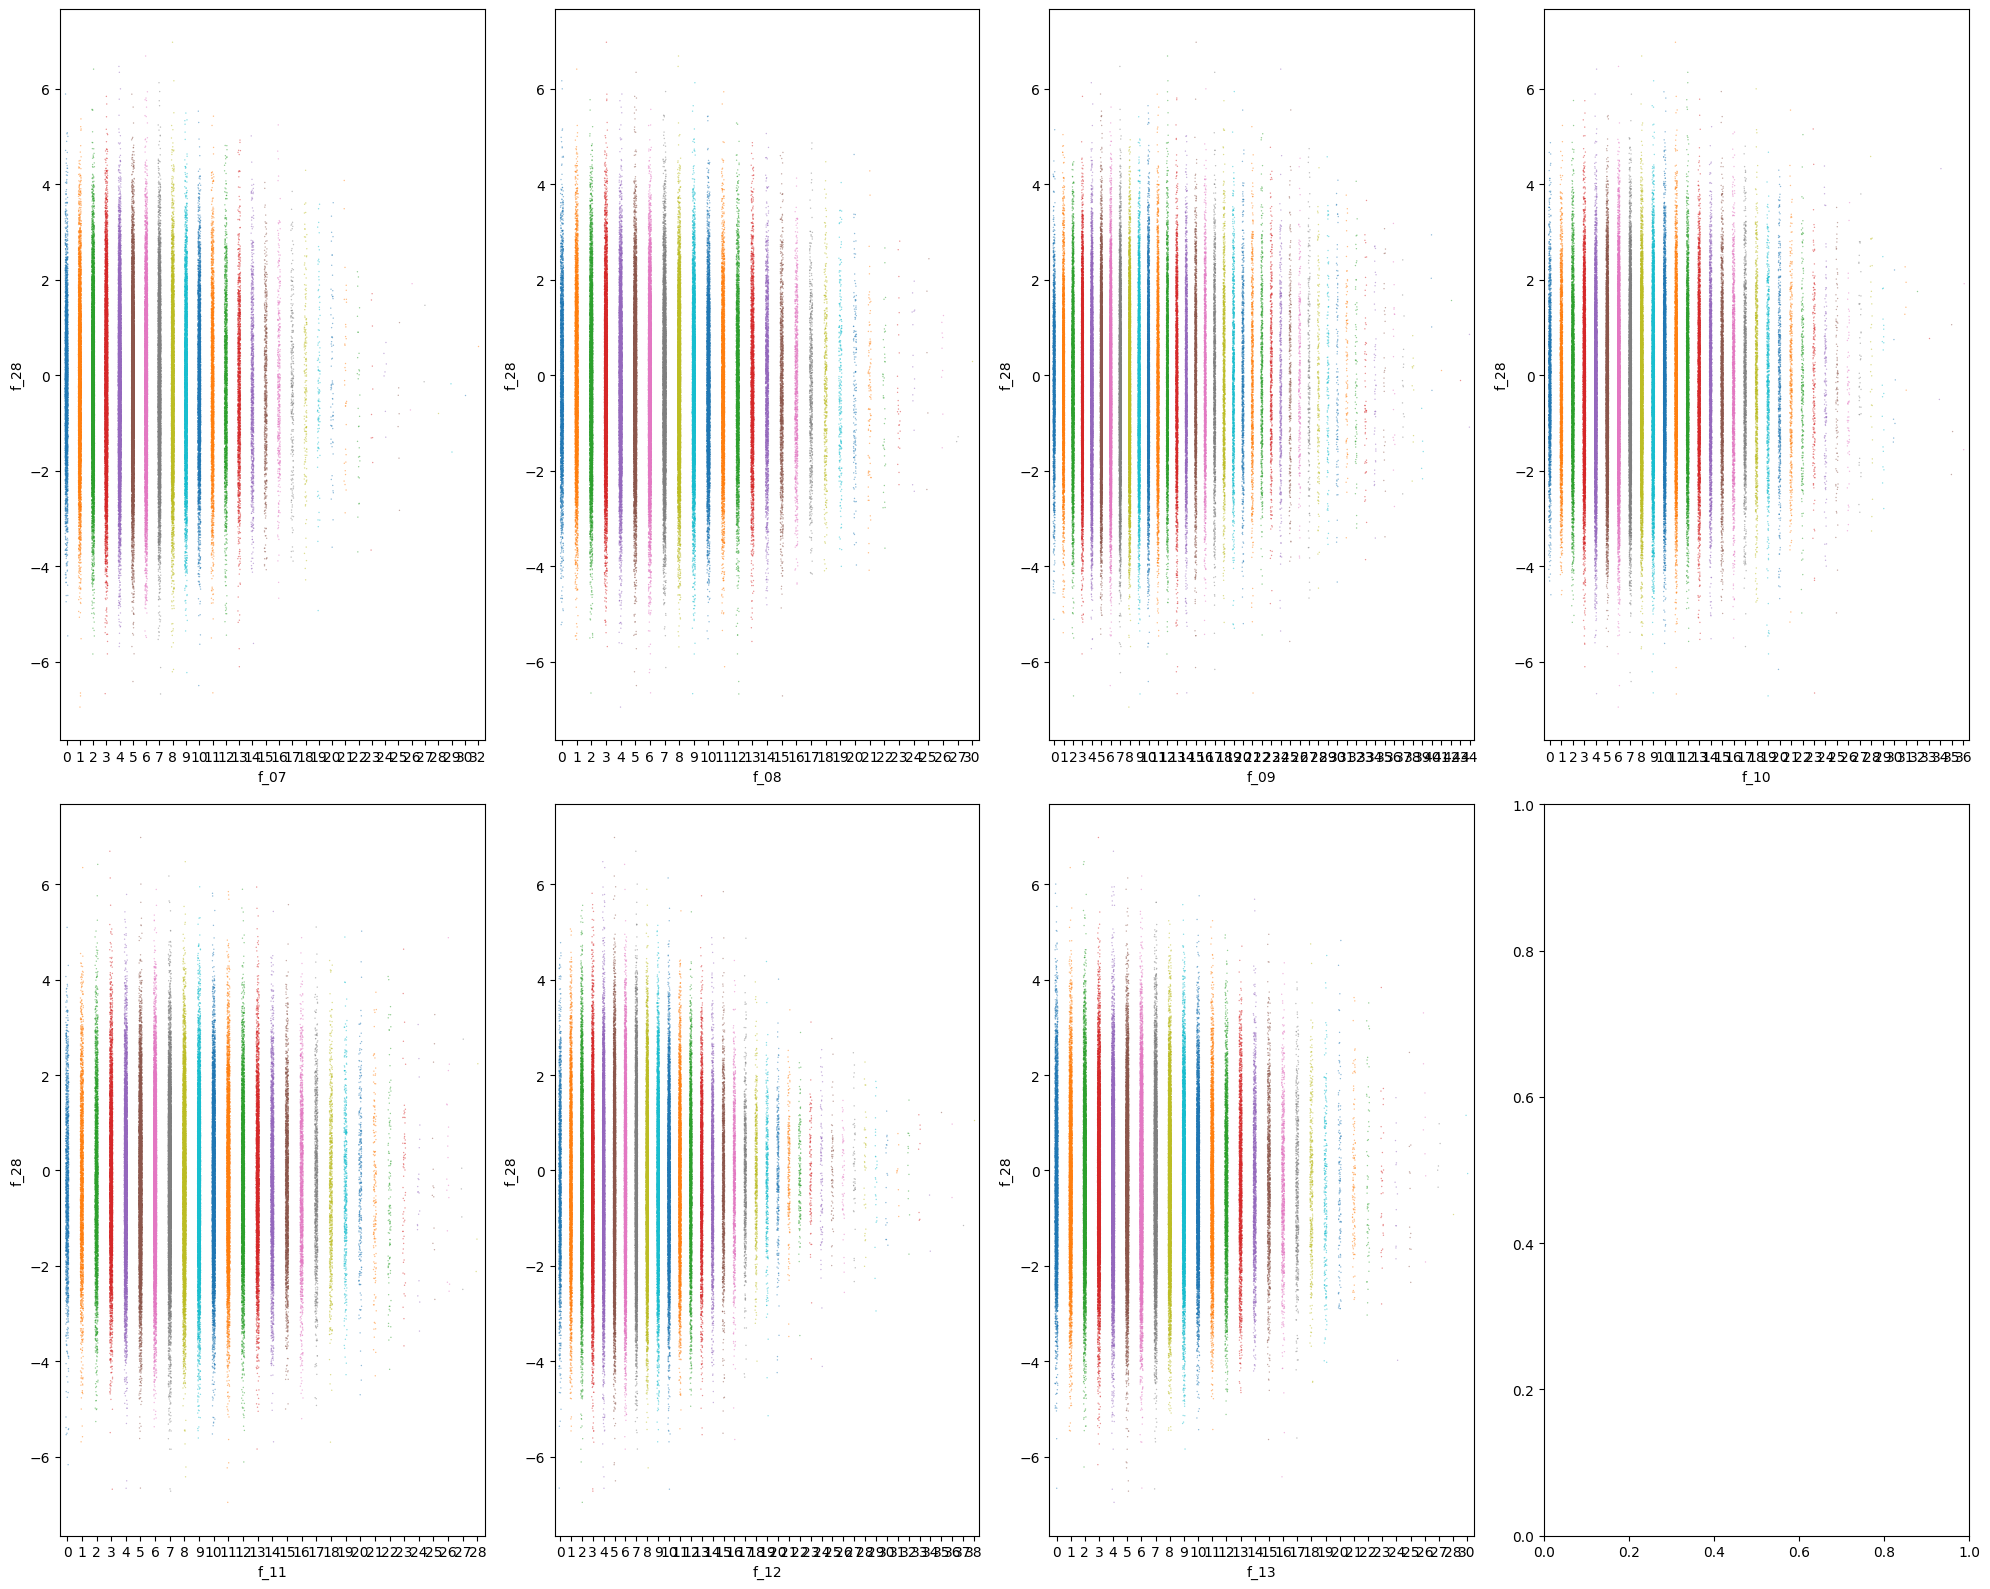

In [78]:
# Establish number of columns and rows needed to plot all features
n_cols = 4
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")

# Specify y_value to spread data (ideally a continuous feature)
y_value = df["f_28"]

# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, 16))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout();

/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/3528932292.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=df["f_28"], ax=ax,
/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/3528932292.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=df["f_28"], ax=ax,
/var/folders/bm/q77j4spj5nsbdchm0916yf5r0000gn/T/ipykernel_20255/3528932292.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x=col, y=df["f_28"], ax=ax,


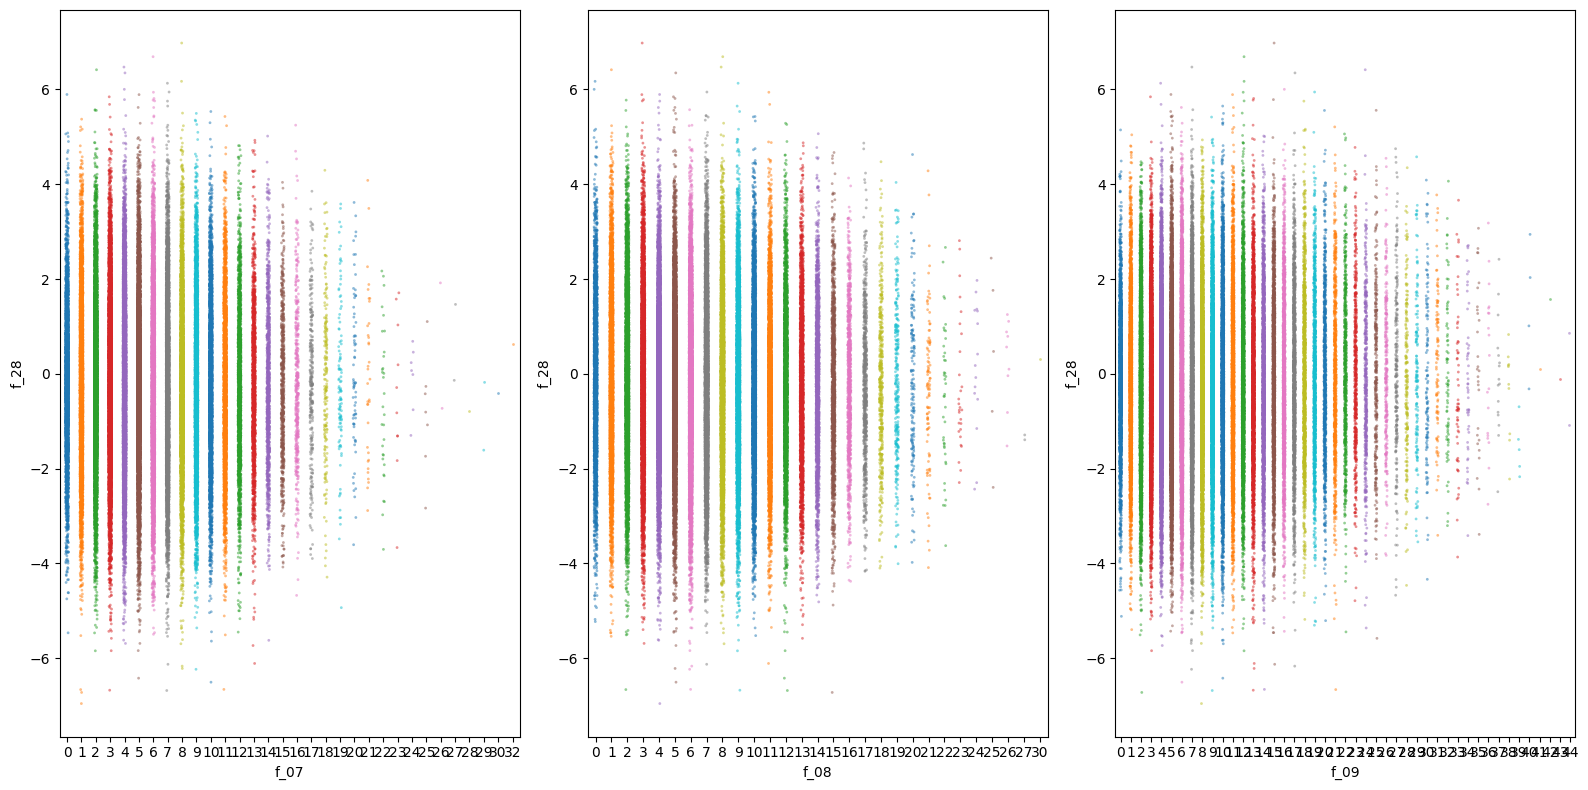

In [80]:
# Specify features of interest 
selected_features = ["f_07", "f_08", "f_09"]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.stripplot(data=df, x=col, y=df["f_28"], ax=ax,
                  palette="tab10", size=2, alpha=0.5)
plt.tight_layout();

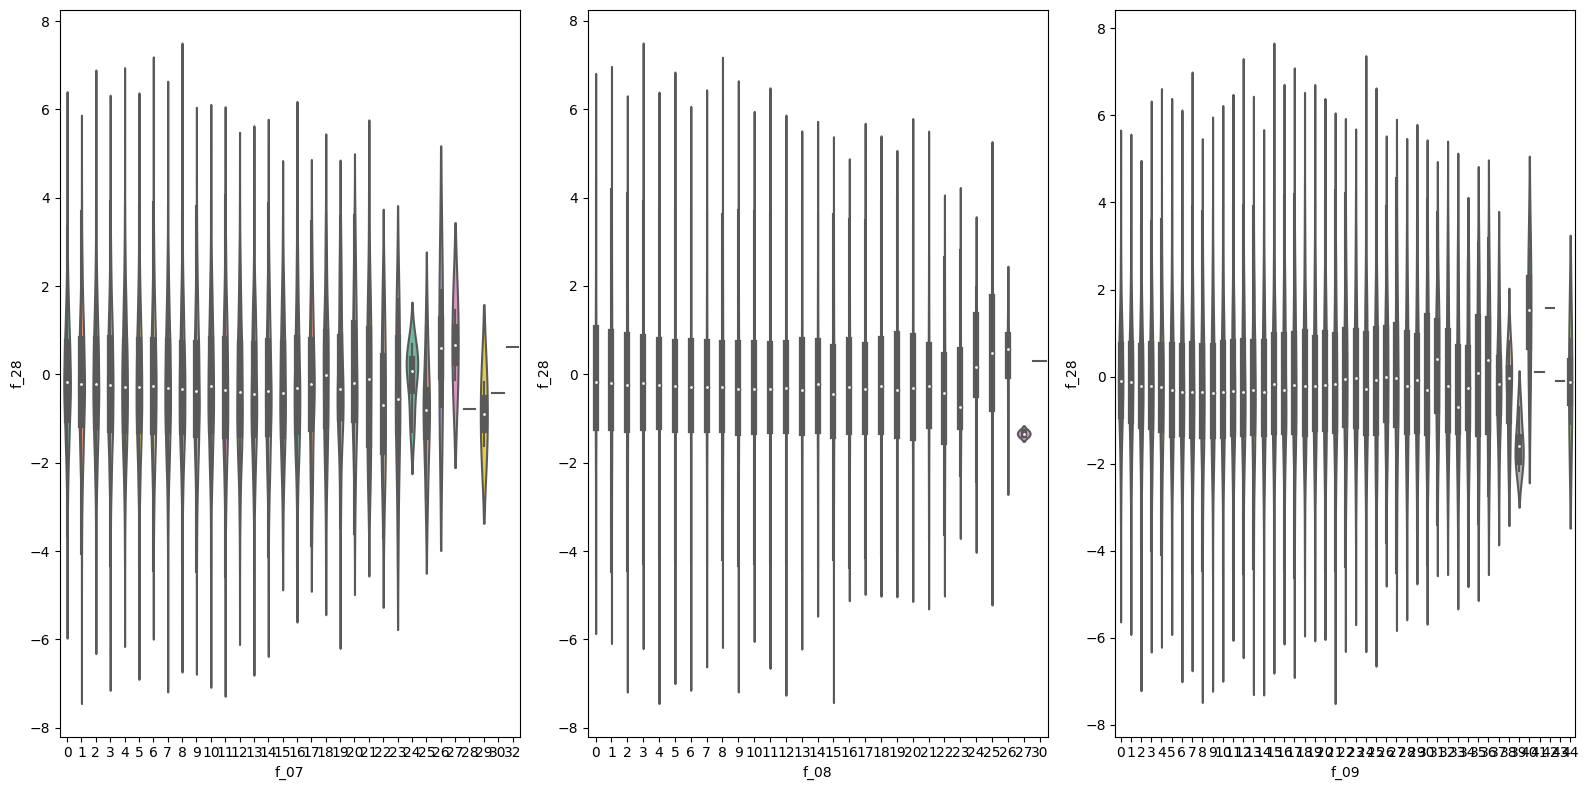

In [85]:
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, x=col, y=df["f_28"], palette="Set2",
                   split=True, ax=ax)
plt.tight_layout();

## Correlation plots

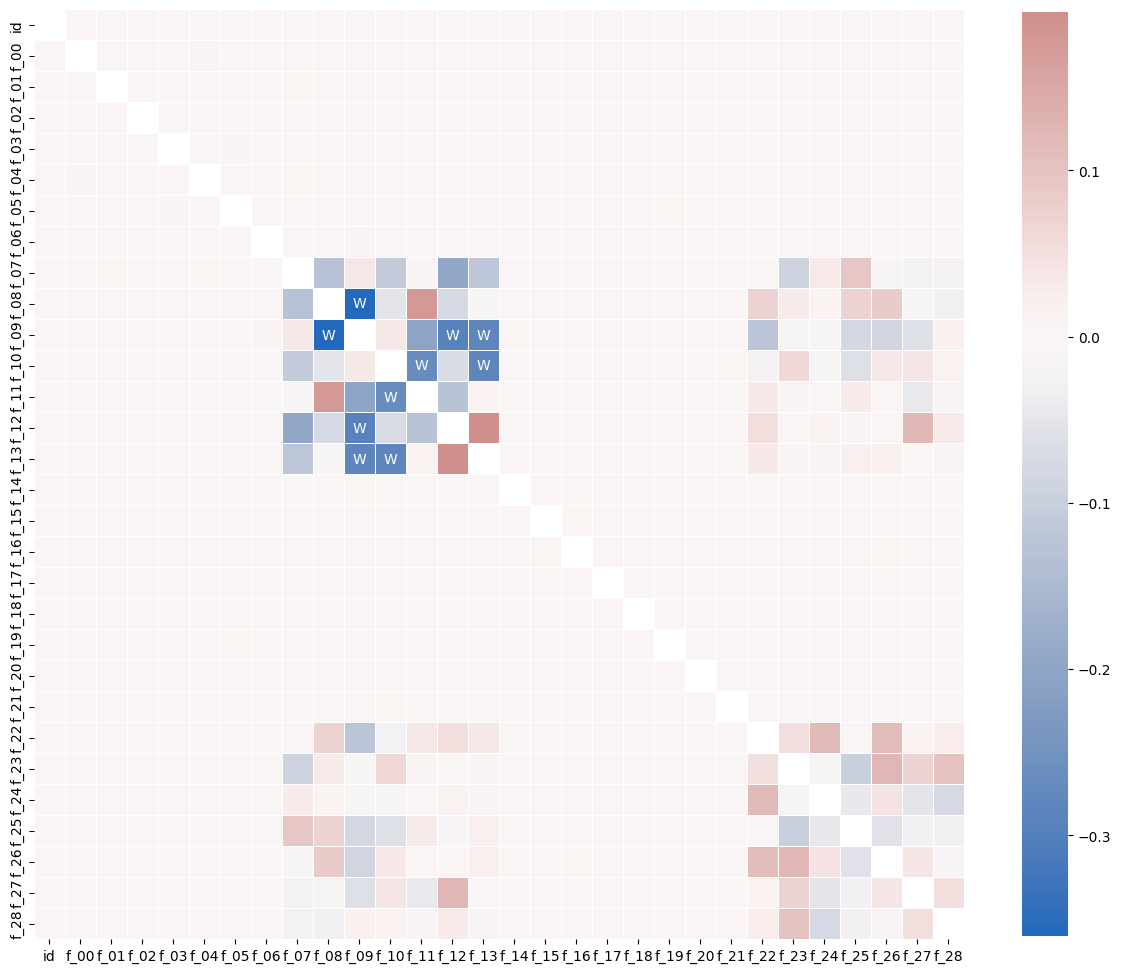

In [86]:
# Computes feature correlation
df_corr = df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

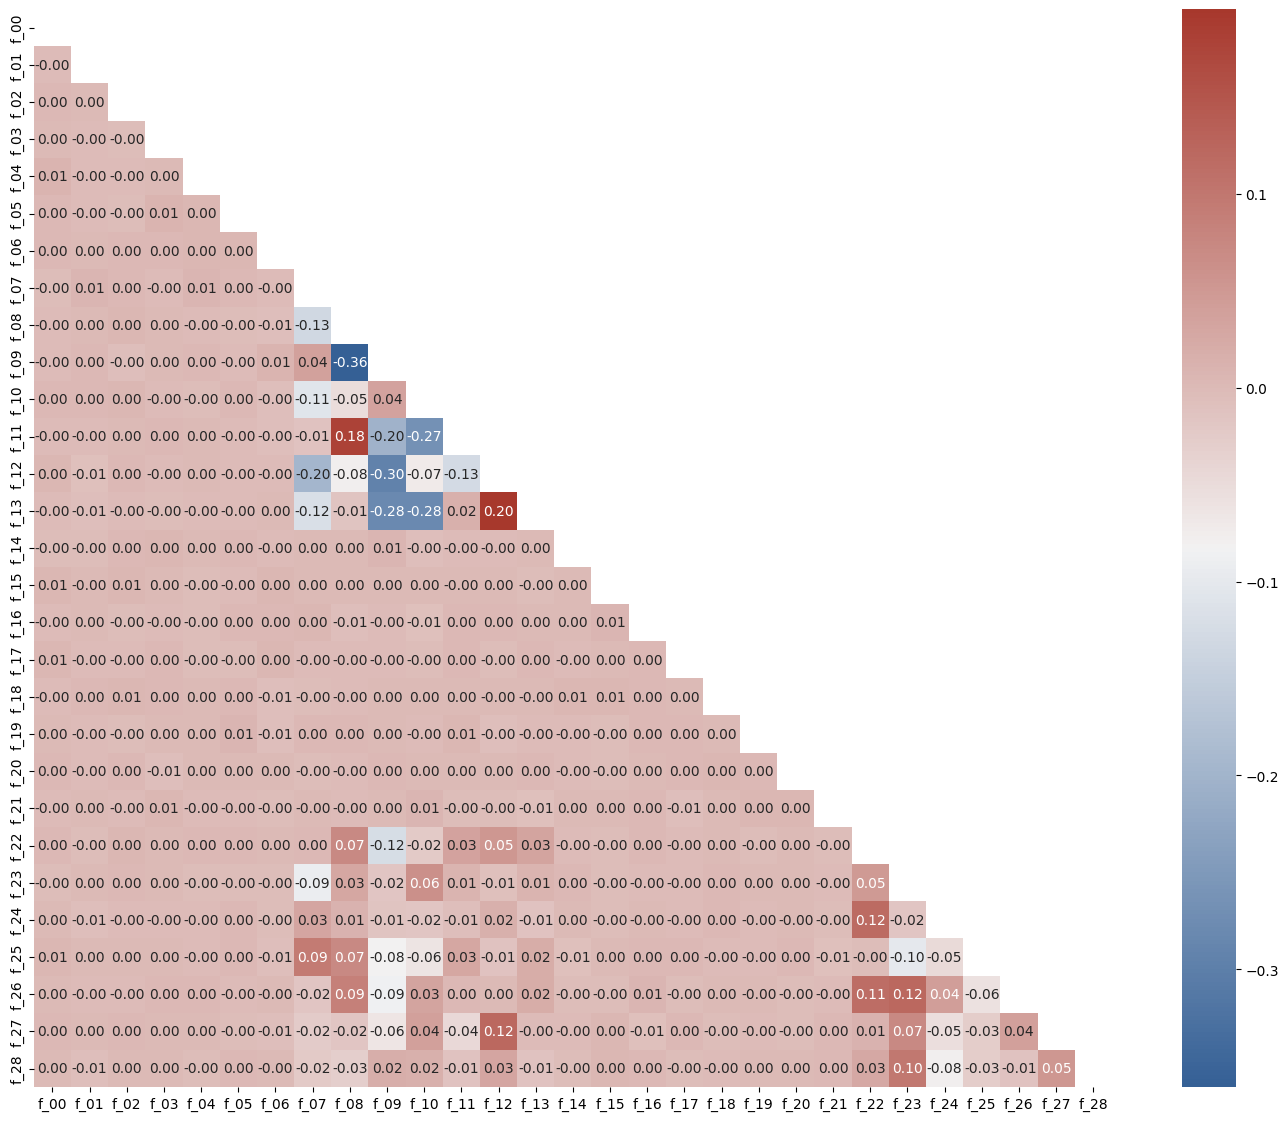

In [90]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
corrMatrix = df.drop('id', axis=1).corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show()

In [87]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

f_09  f_08   -0.360734
f_12  f_09   -0.295563
f_13  f_09   -0.281970
      f_10   -0.281057
f_11  f_10   -0.267171
                ...   
f_24  f_22    0.117363
f_27  f_12    0.122341
f_26  f_23    0.122586
f_11  f_08    0.179527
f_13  f_12    0.195191
Length: 435, dtype: float64